In [1]:
import math
import numpy as np
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
# import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr


sys.path.append('../')

import vsdm
from vsdm.units import *
from vsdm.utilities import *
vsdm.__version__

'0.1.0'

In [2]:
def projLM_r(wave, nlist, ell, m, r):
    # wave: ProjectFnlm object
    out = 0.0
    for n in nlist:
        nlm = (n, ell, m)
        fnlm = wave.f_nlm[nlm].mean
        Rnlm = wave.radRn(n, ell, r)
        out += fnlm*Rnlm
    return out 

"""Analytic result for comparison (radial function).

    f = sum_i c_i tg_i
"""

def g_i_lm(gvec, ell, m, u):
    # No factor of u0**3. g_i has units of 1/sigma**3. 
    (ci, vWsph_i, sigma_i) = gvec
    (ui, theta_i, phi_i) = vWsph_i
    cY_i = ci * vsdm.ylm_real(ell, m, theta_i, phi_i) / sigma_i**3
    factExp = math.exp(-(u-ui)**2/sigma_i**2)
    z = 2*u*ui/sigma_i**2
    if z==0:
        if ell==0:
            factIve = 4/math.sqrt(math.pi)
        else:
            factIve = 0
    else:
        factIve = math.sqrt(8/z) * spf.ive(ell+0.5, z)
    return cY_i * factExp * factIve

def gsum_lm(glist, ell, m, u):
    out = 0.0
    for gvec in glist:
        out += g_i_lm(gvec, ell, m, u)
    return out

def gaussian_stream_sum(ci, vWsph_i, sigma_i):
    # Arguments: lists of amplitudes gi, dispersions v0_i, and 
    #     lab-frame DM wind vectors vWsph_i, in spherical coordinates
    gvec_list = []
    for i in range(len(gi)):
        gaus = (ci[i], vWsph_i[i], sigma_i[i])
        gvec_list += [gaus]
    return gvec_list 

# Define a function to convert GaussianF(gX) into GaussianF(tilde_gX),
# for dimensionless function tilde_gX = u0**3 * gX,
# where u0 is the vsdm.Basis.u0 scale factor
def gX_to_tgX(gauF, u0):
    tgauF_vecs = gauF.rescaleGaussianF(u0**3)
    return vsdm.GaussianFnlm(gauF.basis, tgauF_vecs)


# Radial Convergence

## Function: Gaussian Sum

In [3]:
# Model 4: a bunch of streams, not symmetric. 
# Including the halo component without vEsc.
v0_main = 220*km_s
v0_a = 70*km_s
v0_b = 50*km_s
v0_c = 25*km_s
# vX_main = (230*km_s, np.pi, 0)
# vX_a = (113.13*km_s, 0.75*np.pi, 0) 
# vX_b = (315.28*km_s, 2.067, 4.265)
# vX_c = (1.5*256.71*km_s, 2.912, 0.540)
vX_main = vsdm.cart_to_sph((0, 0, -230*km_s))
vX_a = vsdm.cart_to_sph((80*km_s, 0, -80*km_s))
vX_b = vsdm.cart_to_sph((-120*km_s, -250*km_s, -150*km_s))
vX_c = vsdm.cart_to_sph((50*km_s, 30*km_s, -400*km_s))
sigma_i = [v0_main, v0_a, v0_b, v0_c]
vWsph_i = [vX_main, vX_a, vX_b, vX_c]
gi = [0.4, 0.3, 0.2, 0.1]
gvec_list_4 = gaussian_stream_sum(gi, vWsph_i, sigma_i)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
bdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)
gXmodel_4 = vsdm.GaussianFnlm(bdict, gvec_list_4)
gtilde_4 = gX_to_tgX(gXmodel_4, VMAX)
gvec_tilde_4 = gtilde_4.gvec_list

In [5]:
print(np.array(vsdm.sph_to_cart(vX_main))/km_s)
print(np.array(vsdm.sph_to_cart(vX_a))/km_s)
print(np.array(vsdm.sph_to_cart(vX_b))/km_s)
print(np.array(vsdm.sph_to_cart(vX_c))/km_s)
print(gXmodel_4.distEnergyG()*VMAX**3)
print(gtilde_4.distEnergyG()/VMAX**3)

[ 2.81668764e-14  0.00000000e+00 -2.30000000e+02]
[ 80.   0. -80.]
[-120. -250. -150.]
[  50.   30. -400.]
2603594129.199007
2603594129.1990066


### Numeric evaluation

In [6]:
(ell1, m1) = (0,0)

csvname = 'gX_model4'

gvegas_params = dict(neval=1e4, nitn=7, nitn_init=3, 
                     neval_init=1e3, verbose=True)

"""Read from hdf5..."""
wave4 = vsdm.ProjectFnlm(bdict, gtilde_4, gvegas_params, 
                         nlmlist=None, f_type='gX')
wave4.importFnlm_csv('demo/'+csvname+'.csv')
print('nCoeffs = {}'.format(len(wave4.getNLMlist())))
print('is_gaussian: ', wave4.is_gaussian)
    
#

nCoeffs = 262848
is_gaussian:  True


In [7]:
print(wave4.t_eval)
print(wave4.f_nlm[(0,0,0)])
print(wave4.gU((0,0,0)))
print(wave4.nlmFu((0,0,0)))
print(wave4.nMax)

5.5824103355407715
0.4886014(15)
12.196880994868838
11.244(10)
191


# Plots

In [8]:
unisize = 3.5
plotpoints = 1025
x = np.array([i/plotpoints for i in range(plotpoints+1)])


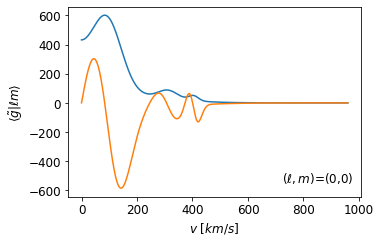

In [9]:
(ell1, m1) = (0, 0)
ur = np.array([xi*VMAX for xi in x])
g4_lm = np.array([gsum_lm(gvec_tilde_4, ell1, m1, u) for u in ur])

du = 0.1 * (ur[4]-ur[3])
dg4_du = np.array([(gsum_lm(gvec_tilde_4, ell1, m1, u+du)
                    - gsum_lm(gvec_tilde_4, ell1, m1, u))/du for u in ur])

plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(ur/km_s, 10*g4_lm, ur/km_s, dg4_du*VMAX)
plt.xlabel(r'$v~[km/s]$', fontsize=12)
plt.ylabel(r'$\langle\tilde{g}|\ell m\rangle$', fontsize=12)
plt.xscale('linear')
plt.yscale('linear')
# plt.title(r'$H = \mathcal{H}/a$ vs proper time')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell1,m1)  
plt.figtext(0.88, 0.17, labeltext, horizontalalignment='right',
            verticalalignment='bottom', fontsize=12)
plt.show() 

In [10]:
gLMr = {}
gLMr[6] = np.array([projLM_r(wave4, [i for i in range(6)], ell1, m1, u) for u in ur])
gLMr[12] = np.array([projLM_r(wave4, [i for i in range(12)], ell1, m1, u) for u in ur])
gLMr[24] = np.array([projLM_r(wave4, [i for i in range(24)], ell1, m1, u) for u in ur])
gLMr[48] = np.array([projLM_r(wave4, [i for i in range(48)], ell1, m1, u) for u in ur])
gLMr[96] = np.array([projLM_r(wave4, [i for i in range(96)], ell1, m1, u) for u in ur])
gLMr[192] = np.array([projLM_r(wave4, [i for i in range(192)], ell1, m1, u) for u in ur])
#
wlist = [6, 12, 24, 48, 96, 192]
interval = np.linspace(0, 1, len(wlist))
colors = [plt.cm.viridis(x) for x in interval]


#

In [11]:
u0_vals = [wave4._baseOfSupport_n(n, getMidpoint=True)[1] 
           for n in range(wave4.nMax+1)]

f0_lm_n = np.array([gsum_lm(gvec_tilde_4, ell1, m1, u) 
                  for u in u0_vals])

f_lm_n = [wave4.f_nlm[(n, ell1, m1)].mean 
          for n in range(wave4.nMax+1)]

w4_cubic = {}
for ncoeffs in wlist:
    nmax = ncoeffs - 1
    w4_cubic[ncoeffs] = wave4.cubic_interpolation(f_lm_n, nmax, f0_lm_n)
    
glm_interp = {}
for ncoeffs in wlist:
    glm_interp[ncoeffs] = w4_cubic[ncoeffs].f_p_u(0, ur)

## Plots

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


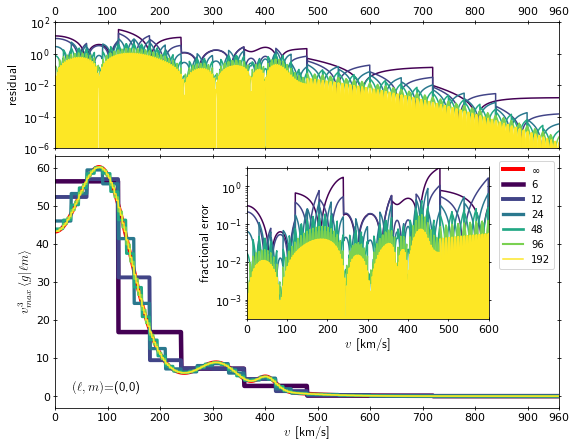

In [12]:
fig = plt.figure(figsize=[2.0*unisize,unisize])
"""Wavelet: Function values"""
vlim = [0,960]
xtix = [0,100,200,300,400,500,600,700,800,900,960]
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
ax.set_xticks(xtix)
ax.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax.set_ylabel(r'$v_{max}^3\,\langle g|\ell m\rangle$', 
              fontsize=13, usetex=True)
ax.plot(ur/km_s, g4_lm, color='red', linewidth=4, label=r'$\infty$')
for i in range(len(wlist)):
    ax.plot(ur/km_s, gLMr[wlist[i]], label=str(wlist[i]),
             color=colors[i], linewidth=(1.5+3*(1-interval[i])))
# ax.plot(vr/km_s, g4_lm, color='black')
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True)
labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell1,m1)  
ax.text(0.035, 0.05, labeltext, horizontalalignment='left',
        verticalalignment='bottom', fontsize=13, 
        transform=ax.transAxes, usetex=True)
ax.set_xlim(vlim)
ax.legend()

"""Wavelet: Errors"""
ax2 = fig.add_axes([0.38,0.35,0.48,0.6], 
                   xscale='linear', yscale='log')
ax2.set_xticks(xtix[:-1])
for i in range(len(wlist)):
    ax2.plot(ur/km_s, gLMr[wlist[i]]/g4_lm-1, label=str(wlist[i]),
             color=colors[i], linewidth=(1.5))
    ax2.plot(ur/km_s, 1-gLMr[wlist[i]]/g4_lm, label=str(wlist[i]),
             color=colors[i], linewidth=(1.5))
ax2.set_ylim([3e-4, 3])
ax2.set_xlim([0,600])
ax2.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True)
ax2.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax2.set_ylabel('fractional error', loc='center', 
               fontsize=13, usetex=True)

ax3 = fig.add_axes([0,1.03,1,0.5], xscale='linear', yscale='log')
ax3.set_xticks(xtix)
ax3.set_xlim(vlim)
for i in range(len(wlist)):
    ax3.plot(ur/km_s, gLMr[wlist[i]]-g4_lm, label=str(wlist[i]),
             color=colors[i], linewidth=(1.5))
    ax3.plot(ur/km_s, g4_lm-gLMr[wlist[i]], label=str(wlist[i]),
             color=colors[i], linewidth=(1.5))
ax3.set_ylim([1e-6, 100])
ax3.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True,  
                labelbottom=False, labeltop=True)
# ax3.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax3.set_ylabel('residual', fontsize=13, usetex=True)



fig.show() 

#

## Extrapolation/Interpolation 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


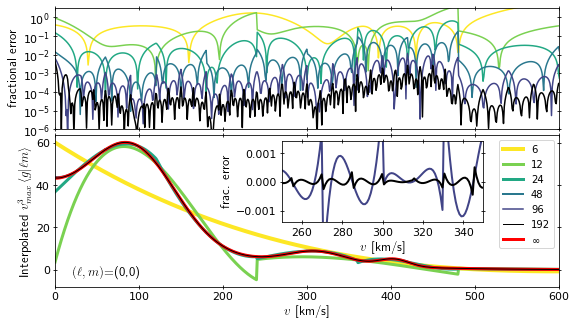

In [13]:
intercolors = [plt.cm.viridis(1-x) for x in interval]
intercolors[-1] = 'black'
# infcolor = plt.cm.viridis(0.99)
infcolor = 'red'
linewidths = [4, 3, 3, 2, 1.5, 1]

fig = plt.figure(figsize=[2.0*unisize,0.8*unisize])
"""Wavelet: Function values"""
vlim = [0,600]
xtix = [0,100,200,300,400,500,600,700,800,900,960]
ax = fig.add_axes([0,0,1,0.75], xscale='linear', yscale='linear')
# ax.set_xticks(xtix)
ax.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax.set_ylabel(r'Interpolated $v_{max}^3\,\langle g|\ell m\rangle$', 
              fontsize=13, usetex=True)
for i in range(0, len(wlist)):
    ax.plot(ur/km_s, glm_interp[wlist[i]], label=str(wlist[i]),
             color=intercolors[i], linewidth=linewidths[i])
ax.plot(ur/km_s, g4_lm, color=infcolor, linewidth=3, label=r'$\infty$')
ax.plot(ur/km_s, glm_interp[wlist[-1]], 
         color=intercolors[i], linewidth=linewidths[-1])
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True)
labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell1,m1)  
ax.text(0.035, 0.05, labeltext, horizontalalignment='left',
        verticalalignment='bottom', fontsize=13, 
        transform=ax.transAxes, usetex=True)
ax.set_xlim(vlim)
# ax.set_ylim([6,9])
ax.legend()

"""Wavelet: Errors"""

ax3 = fig.add_axes([0,0.78,1,0.6], xscale='linear', yscale='log')
# ax3.set_xticks(xtix)
ax3.set_yticks([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
ax3.set_xlim(vlim)
for i in range(0, len(wlist)):
    ax3.plot(ur/km_s, np.abs(glm_interp[wlist[i]]/g4_lm-1), label=str(wlist[i]),
             color=intercolors[i], linewidth=(1.5))
ax3.set_ylim([1e-6, 3])
ax3.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True,  
                labelbottom=False, labeltop=False)
# ax3.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax3.set_ylabel('fractional error', fontsize=13, usetex=True)

ax_inset = fig.add_axes([0.45,0.32,0.4,0.4], xscale='linear', yscale='linear')
# ax_inset.set_xticks(xtix)
ax_inset.set_xlim([250,350])
ax_inset.set_ylim([-1.4e-3, 1.4e-3])
# ax_inset.set_yticks([-0.02, -0.01, 0, 0.01, 0.02])
for i in range(4, len(wlist)):
    ax_inset.plot(ur/km_s, (glm_interp[wlist[i]]/g4_lm - 1), label=str(wlist[i]),
                  color=intercolors[i], linewidth=(2))
ax_inset.tick_params(axis='both', labelsize=11, direction='inout',
                     right=True, top=True,  
                     labelbottom=True, labeltop=False)
ax_inset.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax_inset.set_ylabel('frac. error', fontsize=13, usetex=True)


fig.show() 

#

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


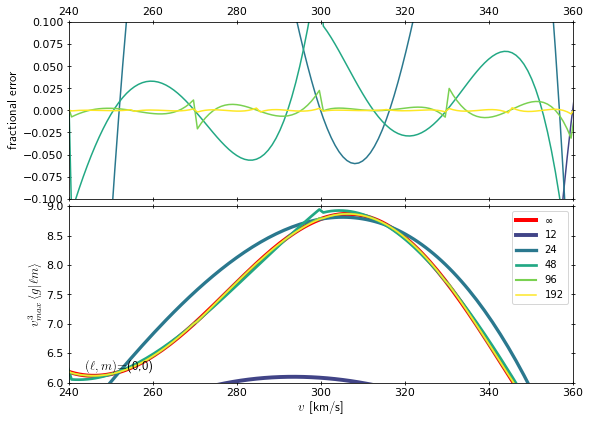

In [14]:
fig = plt.figure(figsize=[2.0*unisize,unisize])
"""Wavelet: Function values"""
vlim = [240,360]
xtix = [0,100,200,300,400,500,600,700,800,900,960]
ax = fig.add_axes([0,0,1,0.7], xscale='linear', yscale='linear')
# ax.set_xticks(xtix)
ax.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax.set_ylabel(r'$v_{max}^3\,\langle g|\ell m\rangle$', 
              fontsize=13, usetex=True)
ax.plot(ur/km_s, g4_lm, color='red', linewidth=4, label=r'$\infty$')
for i in range(1, len(wlist)):
    ax.plot(ur/km_s, glm_interp[wlist[i]], label=str(wlist[i]),
             color=colors[i], linewidth=(1.5+3*(1-interval[i])))
# ax.plot(vr/km_s, g4_lm, color='black')
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True)
labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell1,m1)  
ax.text(0.035, 0.05, labeltext, horizontalalignment='left',
        verticalalignment='bottom', fontsize=13, 
        transform=ax.transAxes, usetex=True)
ax.set_xlim(vlim)
ax.set_ylim([6,9])
ax.legend()

"""Wavelet: Errors"""

ax3 = fig.add_axes([0,0.73,1,0.7], xscale='linear', yscale='linear')
# ax3.set_xticks(xtix)
ax3.set_xlim(vlim)
for i in range(1, len(wlist)):
    ax3.plot(ur/km_s, (glm_interp[wlist[i]]-g4_lm), label=str(wlist[i]),
             color=colors[i], linewidth=(1.5))
ax3.set_ylim([-1e-1, 1e-1])
ax3.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True,  
                labelbottom=False, labeltop=True)
# ax3.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax3.set_ylabel('fractional error', fontsize=13, usetex=True)



fig.show() 

#

## Second version of (l,m)...

In [15]:
(ell2, m2) = (2, 0)
# ur2 = np.array([xi*VMAX for xi in x])
ur2 = np.array([0.499*xi*VMAX for xi in x])
ur2 = ur2[:-1]
g4_lm = np.array([gsum_lm(gvec_tilde_4, ell2, m2, u) for u in ur2])

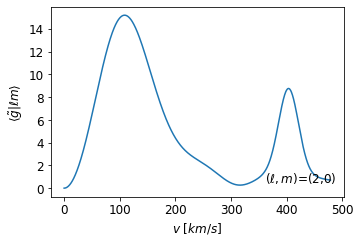

In [16]:
plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(ur2/km_s, g4_lm)
plt.xlabel(r'$v~[km/s]$', fontsize=12)
plt.ylabel(r'$\langle\tilde{g}|\ell m\rangle$', fontsize=12)
plt.xscale('linear')
plt.yscale('linear')
# plt.title(r'$H = \mathcal{H}/a$ vs proper time')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell2,m2)  
plt.figtext(0.88, 0.17, labeltext, horizontalalignment='right',
            verticalalignment='bottom', fontsize=12)
plt.show() 

In [17]:
gLMr = {}
gLMr[6] = np.array([projLM_r(wave4, [i for i in range(6)], ell2, m2, u) for u in ur2])
gLMr[12] = np.array([projLM_r(wave4, [i for i in range(12)], ell2, m2, u) for u in ur2])
gLMr[24] = np.array([projLM_r(wave4, [i for i in range(24)], ell2, m2, u) for u in ur2])
gLMr[48] = np.array([projLM_r(wave4, [i for i in range(48)], ell2, m2, u) for u in ur2])
gLMr[96] = np.array([projLM_r(wave4, [i for i in range(96)], ell2, m2, u) for u in ur2])
gLMr[192] = np.array([projLM_r(wave4, [i for i in range(192)], ell2, m2, u) for u in ur2])
#
wlist = [6, 12, 24, 48, 96, 192]
interval = np.linspace(0, 1, len(wlist))




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.f

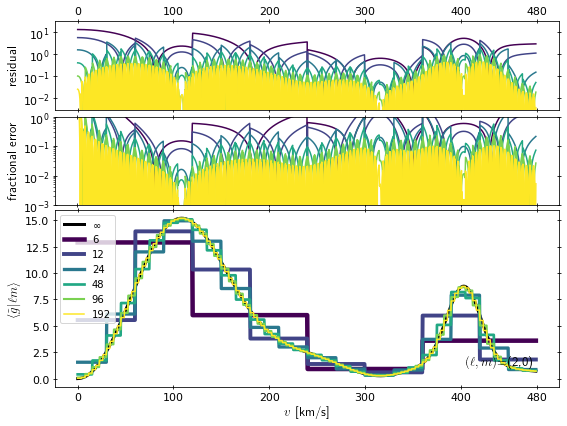

In [18]:
# colors = [plt.cm.viridis(1-x) for x in interval]
# colors = [plt.cm.plasma(x) for x in interval]
colors = [plt.cm.viridis(x) for x in interval]


fig = plt.figure(figsize=[2.0*unisize,0.7*unisize])
"""Wavelet: Function values"""
xtix = [0,100,200,300,400,480]
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
ax.set_xticks(xtix)
ax.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax.set_ylabel(r'$\langle\tilde{g}|\ell m\rangle$', 
              fontsize=13, usetex=True)
ax.plot(ur2/km_s, g4_lm, color='black', linewidth=3, 
        label=r'$\infty$')
for i in range(len(wlist)):
    ax.plot(ur2/km_s, gLMr[wlist[i]], label=str(wlist[i]),
             color=colors[i], linewidth=(1.5+3*(1-interval[i])))
# ax.plot(vr/km_s, g4_lm, color='black')
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True)
labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell2,m2)  
ax.text(0.95, 0.1, labeltext, horizontalalignment='right',
        verticalalignment='bottom', fontsize=13, 
        transform=ax.transAxes, usetex=True)
ax.legend(loc='upper left')

"""Wavelet: Errors"""
# ax2 = fig.add_axes([0.43,0.35,0.55,0.6], 
#                    xscale='linear', yscale='log')
# ax2.set_xticks(xtix[:-1])
# for i in range(len(wlist)):
#     ax2.plot(ur2/km_s, gLMr[wlist[i]]/g4_lm-1, label=str(wlist[i]),
#              color=colors[i], linewidth=(1.5))
#     ax2.plot(ur2/km_s, 1-gLMr[wlist[i]]/g4_lm, label=str(wlist[i]),
#              color=colors[i], linewidth=(1.5))
# ax2.set_ylim([1e-3, 1])
# ax2.tick_params(axis='both', labelsize=11, direction='inout',
#                 right=True, top=True)
# ax2.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
# ax2.set_ylabel('fractional error', loc='top', 
#                fontsize=13, usetex=True)

ax3 = fig.add_axes([0,1.03,1,0.5], xscale='linear', yscale='log')
ax3.set_xticks(xtix)
for i in range(len(wlist)):
    ax3.plot(ur2/km_s, gLMr[wlist[i]]/g4_lm-1, label=str(wlist[i]),
             color=colors[i], linewidth=(1.5))
    ax3.plot(ur2/km_s, 1-gLMr[wlist[i]]/g4_lm, label=str(wlist[i]),
             color=colors[i], linewidth=(1.5))
ax3.set_ylim([1e-3, 1])
ax3.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True,  
                labelbottom=False, labeltop=False)
# ax3.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax3.set_ylabel('fractional error', fontsize=13, usetex=True)

ax4 = fig.add_axes([0,1.57,1,0.5], xscale='linear', yscale='log')
ax4.set_xticks(xtix)
ax4.set_yticks([1e-2, 1e-1, 1, 10])
for i in range(len(wlist)):
    ax4.plot(ur2/km_s, gLMr[wlist[i]]-g4_lm, label=str(wlist[i]),
             color=colors[i], linewidth=(1.5))
    ax4.plot(ur2/km_s, g4_lm-gLMr[wlist[i]], label=str(wlist[i]),
             color=colors[i], linewidth=(1.5))
ax4.set_ylim([3e-3, 30])
ax4.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True,  
                labelbottom=False, labeltop=True)
ax4.set_ylabel('residual', fontsize=13, usetex=True)

# ax4 = fig.add_axes([0,1.57,1,0.5], xscale='linear', yscale='linear')
# ax4.set_xticks(xtix)
# for i in range(len(wlist)):
#     ax4.plot(ur2/km_s, gLMr[wlist[i]]-g4_lm, label=str(wlist[i]),
#              color=colors[i], linewidth=(1.5))
# #     ax4.plot(ur2/km_s, g4_lm-gLMr[wlist[i]], label=str(wlist[i]),
# #              color=colors[i], linewidth=(1.5))
# ax4.set_ylim([-1, 1])
# ax4.tick_params(axis='both', labelsize=11, direction='inout',
#                 right=True, top=True,  
#                 labelbottom=False, labeltop=True)
# ax4.set_ylabel('residual', fontsize=13, usetex=True)

fig.show() 

#